Contenido bajo licencia Creative Commons BY 4.0 y código bajo licencia MIT. © Juan Gómez y Nicolás Guarín-Zapata 2020. Este material es parte del curso Modelación Computacional en el programa de Ingeniería Civil de la Universidad EAFIT.

# Interpolación en 2D

## Introducción

Acá extenderemos el esquema de interpolación unidimensional estudiado previamente al caso mas general de un dominio bidimensional. Desde el punto de vista geométrico también veremos como un **elemento finito** es solo un dominio espacial canónico descrito por puntos nodales y el correspondiente grupo de funciones de interpolación (o de **forma**).


**Al completar este notebook usted debería estar en la capacidad de:**

* Reconocer el problema de interpolación en dominios bidimensionales como uno de aplicación de los esquemas unidimensionales.

* Formalizar el concepto de un elemento finito como un espacio de interpolación canónico con funciones de interpolación predefinidas.

* Proponer esquemas de interpolación para dominios bidimensionales arbitrarios.

## Dominio bidimensional


Consideremos el dominio cuadrado mostrado en la figura y en el cual queremos aproximar, por medio de interpolación, una función escalar (o vectorial) $f=f(x,y)$. Para ese propósito los puntos negros en la figura representan puntos nodales donde asumimos que la función es conocida. En este caso el polinomio de interpolación, denotado por $p(x,y)$ se construye como:

$$p(x,y) = \sum_{Q=1}^N H_Q(x,y)f_Q$$

donde $Q = 1,...,N$ para un dominio de *N* puntos nodales y donde $H_Q(x,y)$ son las funciones de interpolación o funciones de forma.


Como se detallará a continuación para construir las funciones de interpolación bidimensionales $ H_Q(x,y)$  en realidad aplicamos un proceso de interpolaciones unidimensionales iteradas.

Denotemos como $x_A$ y $x_B$ a las coordenadas de los puntos A y B en el dominio cuadrilátero mostrado en la figura y supongamos que queremos encontrar el valor de la función en el punto A.

<center>
    <img src="img/interp_dominio-2D.svg"
         alt="Dominio 2D para interpolación."
         style="width:300px">
</center>

El punto A tiene una coordenada en $y$ que es arbitraria pero una coordenada en $x$ constante correspondiente a $x = x_A$ de manera que para un punto A arbitrario a lo largo de la dirección 1-4 (ver figura) el esquema de interpolación es aún unidimensional solamente con dependencia en $y$ y expresado como $f(y , x= A)$ en la figura. Usando polinomios de interpolación de Lagrange unidimensionales la dependencia en $y$ puede ser capturada por:

$$f(x_A , y) = L_1(y) f_1 + L_4(y) f_4$$


<center>
    <img src="img/inter1D.svg"
         alt="Corte del dominio."
         style="width:300px">
</center>

Procediendo de manera similar para un punto arbitrario $B$ a lo largo de la dirección 2-3 se tiene que:

$$f(x_B, y) = L_2(y) f_2 + L_3(y) f_3\, .$$

con $f_A$ y $f_B$ conocidos la dependencia en $x$ puede capturarse como:

$$f(x, y) = L_A(x) f(x_A, y) + L_B(x)f(x_B, y)\, .$$

Para llegar a la forma final de las funciones de forma bidimensionales calculamos los polinomios $L_2(y)$, $L_3(y)$, $ L_A(x)$ y $L_B(x)$ y los reemplazamos en las expresiones anteriores. En el caso de un elemento de lado $2.0$ las funciones son:

\begin{align*}
H_1(x,y) & = L_1(x)L_1(y) \equiv \frac{1}{4}(1-x)(1-y)\, ,\\
H_2(x,y) & = L_2(x)L_1(y) \equiv \frac{1}{4}(1+x)(1-y)\, ,\\
H_3(x,y) & = L_2(x)L_2(y) \equiv \frac{1}{4}(1+x)(1+y)\, ,\\
H_4(x,y) & = L_1(x)L_2(y) \equiv \frac{1}{4}(1-x)(1+y)\, .
\end{align*}

### Elemento finito canónico



En la siguiente subrutina codificamos la forma final $H_Q(x,y)$ de las funciones de forma en vez de calcular directamente los polinomios fundamentales en una dimensión de la forma $L_I(y)$ para posteriormente realizar la interpolación iterada. La subrutina llamada ``sha4`` almacena las funciones en una estructura matricial que depende de $x$ e $y$. Asumimos que el elemento es un cuadradado perfecto de lado $\mathcal{l}=2.0$ con puntos nodales en las esquinas correspondiente a una interpolación lineal a lo largo de cada cara.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

In [2]:
%matplotlib notebook
sym.init_printing()

In [3]:
def sha4(x, y):
    """
    Compute the shape functions for bi-linear
    square element of size 2.0.
    """
    sh = sym.Matrix([[
            (1 - x)*(1 - y),
            (1 + x)*(1 - y),
            (1 + x)*(1 + y),
            (1 - x)*(1 + y)]])/4
    return sh

Este elemento cuadrado es un elemento **canónico** o de referencia en el cual es fácil la realización de las operaciones de interpolación. En una malla real de elementos finitos es de esperar que los elementos estén distorsionados en relación con este elemento canónico. En esos casos la interpolación también se realiza en el espacio del elemento canónico pero ahora tanto la geometría como las funciones son transformadas usando operaciones matemáticas. Estos detalles sin embargo no se discutirán acá.

Las funciones de forma almacenadas en la subrutina corresponden a:

$$H = \frac{1}{4}\begin{bmatrix}(1-x)(1-y)&(1+x)(1-y)&(1+x)(1+y)&(1-x)(1+y)\end{bmatrix}$$


<div class="alert alert-warning">

**Preguntas**
    
- Escriba las funciones de forma asumiendo que el sub-dominio el mismo cuadrado discutido hasta el momento, pero además de los nodos de la esquina también incluye nodos en la mitad de las caras para completar un total de 8 puntos nodales.

- Haga una copia de la subrutina `sha4` y modifíquela para que calcule las funciones de forma para el elemento de 8 nodos.
</div>

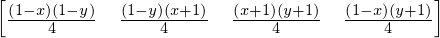

In [4]:
x, y= sym.symbols('x y')
H = sha4(x, y)
display(H)

## Interpolación en un dominio cuadrado

En este paso consideramos un elemento cuadrado conformado por 4 puntos nodales localizados en las esquinas y donde se asumen conocidos los valores de la función. Usaremos estos valores, conjuntamente con las funciones de forma para encontrar un polinomio de interpolación. El polinomio resultante se usa posteriormente para generar valores aproximados de la función en una serie de puntos que conforman una grilla usada para visualizar la solución. La grilla de puntos de observación se genera usando la función `mgrid` de `numpy`.

Note que el sistema de referencia se localiza en el centro del elemento por lo tanto $x \in [-1, 1]$ and $y \in [-1, 1]$. El arreglo unidimensional `u_interp` almacenará los valores interpolados en cada punto de la grilla.

Para realizar la interpolación asumiremos valores nodales de la función en un punto dado $(x , y)$  de manera que podemos obtener el valor interpolado como:

$$u(x,y)\;=\;\left[H(x,y)\right]\left\{u\right\}$$

<IPython.core.display.Javascript object>


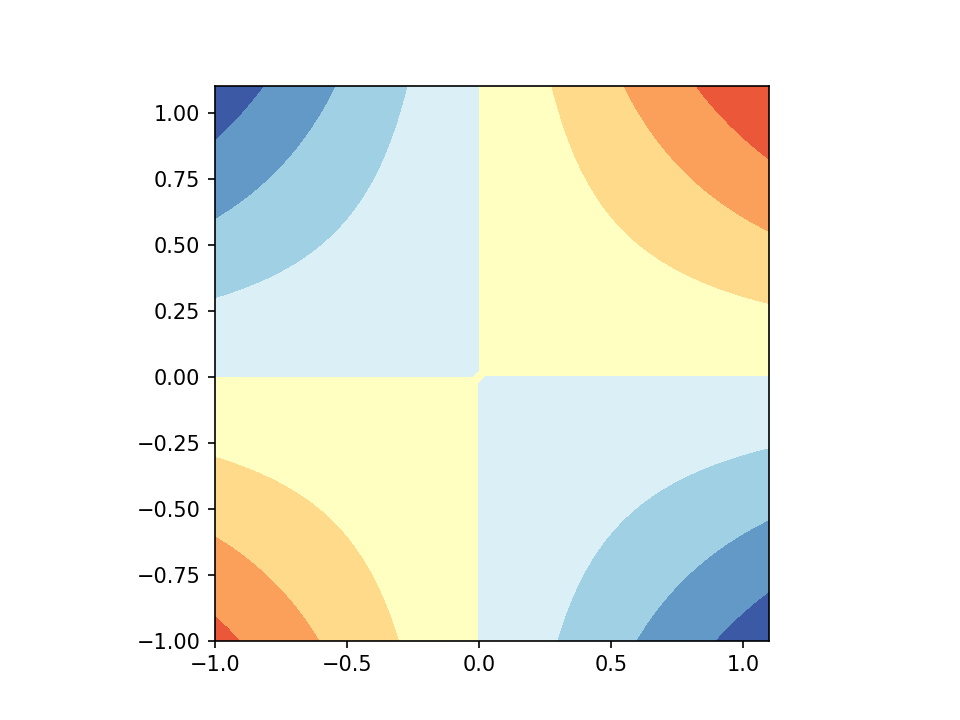

In [5]:
# Agregue comentarios para aclarar los pasos mas relevantes del siguiente código
li = -1.0
ls = 1.1
dl = 0.05
npts = int((ls - li)/dl)
u_interp = np.zeros((npts, npts))
xx, yy = np.mgrid[li:ls:npts*1j, li:ls:npts*1j]

# Intente diferentes valores nodales
u = sym.Matrix(4, 1, [-0.2, 0.2, -0.2, 0.2])
for i in range(npts):
    for j in range(npts):
        NS = H.subs([(x, xx[i,j]), (y, yy[i,j])])
        up = NS*u
        u_interp[i, j] = up[0]
plt.figure()
plt.contourf(xx, yy, u_interp, cmap="RdYlBu")
plt.axis("image")

### Glosario de términos

**Elemento finito canonico:** Sub-dominio no distorsionado de tamaño constante y con funciones de forma únicas. En un caso práctico los elementos difieren en tamaño y nivel de distorión, sin embargo todos ellos son transformados al elemento canónico.

**Funciones de forma:** Funciones de interpolación formuladas sobre un elemento canónico.

**Malla:** Conjunto de elementos finitos que cubren un dominio computacional dado. Se dice que una malla ha sido refinada cuando el tamaño característico de sus elementos se reduce produciendo un mayor número de elementos para cubrir el mismo dominio computacional.

## Actividades para la clase



### Problema 1

Extender el esquema de interpolación en 2D discutido previamente al caso de una función vectorial en el contexto de teoría de la elasticidad con las siguientes consideraciones:

* Asuma que el vector de desplazamientos con componentes horizontal y vertical $u$ y $v$ respectivamente es conocido en cada nodo del dominio cuadrado.

* Usando los valores nodales del vector de desplazamientos calcule las componentes horizontal y vertical a lo largo del elemento (al interior).

* Usando los valores nodales calculo el campo de deformaciones unitarias definido por:

$$\varepsilon_{xx}=\frac12\left(\frac{\partial u}{\partial x}\right)$$

$$\varepsilon_{yy}=\frac12\left(\frac{\partial v}{\partial y}\right)$$

$$\gamma_{yy}=\left(\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x}\right)$$

* Almacene las derivadas de las funciones de forma en una matriz independiente $B$.

### Problema 2

En la actividad que se describe a continuación aplicaremos algunas de las capacidades intrínsecas de interpolación disponibles en Python para resolver un problema de interés en Ingeniería Civil. Utilizaremos algunas funciones del módulo `geopandas` para crear un `GeoDataFrame` a partir de información almacenada en un archivo en [formato shp](https://en.wikipedia.org/wiki/Shapefile) que contiene la geometría de los municipios del Valle de Aburrá.
También utilizaremos la información de las coordenadas, altitudes y aceleraciones de las estaciones de la red acelerográfica que se encuentran en formato csv (archivo separado por comas, del inglés _comma separated value_). Posteriormente, usaremos la información de las estaciones acelerográficas para visualizar las altitudes y aceleraciones máximas. Para esto, Python usa un objeto denominado `Triangulation` que permite realizar operaciones de interpolación y graficación de manera simple.

<div class="alert alert-warning">

**Antes de iniciar la actividad**

Consultar el significado de los siguientes términos:
    
* Módulo `geopandas`:

* GeoDataFrame:

* Análisis geo-espacial:

* Archivo de formato shape:

* `Triangulation`:
</div>



Uno de los insumos fundamentales para el diseño de estructuras sismo-resistentes es la aceleración máxima del terreno que se puede esperar ante la ocurrencia de un sismo. Existe amplia evidencia teórica y experimental de que el tren de ondas incidentes desde la fuente, y por ende los movimientos resultantes en el terreno, se ven fuertemente afectados por la topografía superficial. A este fenómeno se le conoce como efectos topográficos.

En el caso del Valle de Aburrá, sobre el cual descansa la ciudad de Medellín, se conoce que este está conformado por una zona relativamente plana y uniforme en el centro del valle, pero que esta rodeado por un perfil topográfico con laderas de pendiente considerable y que pueden generar efectos topográficos. Para tratar de identificar si efectivamente tales efectos son importantes en la ciudad de Medellín se propone utilizar los registros acelerográficos del sismo de Armenia, 1999, capturados por los equipos de la Red Acelerográfica de Medellín (RAM) y tratar de identificar si existe alguna correlación entre las aceleraciones máximas de dichos registros y la topografía del valle. Para estudiar el problema se dispone de los siguientes archivos.

* Archivo separado por comas (csv) denominado `estaciones_siata.csv` el cual contiene información de latitud (columna 2), longitud (columna 3) y altitud (columna 6) para las diferentes estaciones de la RAM. Adicionalmente las columnas 8, 9 y 10 contienen las componentes Norte-Sur, Este-Oeste y vertical de la aceleración máxima del terreno (cm/s²) registrados durante el sismo de Armenia, Colombia, 1999.

* Archivo de extensión `shp` denominado "medellin_colombia_osm_admin.shp" el cual contiene un mapa de Medellín.

* Archivos separados por comas conteniendo los registros acelerográficos para las estaciones de la RAM.

Usando estos archivos se requiere:

* Leer el archivo `shp` que contiene el mapa de Medellín y visualizarlo (usando los módulos `geopandas` y `matplotlib`).

* Leer el archivo `estaciones_siata.csv` para extraer de allí la localización de las estaciones y posteriormente graficarlas sobre el mapa de Medellín.

* Utilizar la función `tricontourf()` para interpolar y visualizar la distribución de la altitud sobre el mapa de Medellín.

* Utilizar la función `tricontourf()` para interpolar y visualizar la distribución de cada una de las componentes de la aceleración sobre el mapa de Medellín.

* Usando las visualizaciones de altitud y de aceleraciones máximas correlacionar estas 2 variables para identificar si hay efectos topográficos.

**Nota: Reportar sus resultados completando este Notebook**

## Formato del notebook

La siguiente celda cambia el formato del Notebook.

In [6]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)
css_styling()